In [465]:
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt
import altair as alt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from prettytable import PrettyTable, TableStyle

# Data Analysis Begins

- Load data

In [466]:
def load_data(option: str = "1985-2023") -> pd.DataFrame:
    df = pd.DataFrame()
    if option == "1985-2023":
        df = pd.read_excel("../data/tentative_final_with_NaN.xlsx")
    if option == "2010-2023":
        df = pd.read_excel("../data/tentative_final.xlsx")
    return df

### Load and view data

In [467]:
# crime_dataframe = pd.read_excel("../data/tentative_final.xlsx")
# df = crime_dataframe.set_index(["County", "Year"])
# df.head()
tentative_df = load_data()
tentative_df

County  Year  Population  crime_rate  clearance_rate  \
0     Alameda  1985     1185500    0.009809        0.004580   
1     Alameda  1986     1206900    0.010353        0.004615   
2     Alameda  1987     1220600    0.009588        0.005164   
3     Alameda  1988     1242300    0.008825        0.004595   
4     Alameda  1989     1261200    0.008375        0.004163   
...       ...   ...         ...         ...             ...   
2257     Yuba  2019       79619    0.004095        0.001683   
2258     Yuba  2020       81178    0.004977        0.001983   
2259     Yuba  2021       82091    0.004312        0.001815   
2260     Yuba  2022       82563    0.003379        0.001466   
2261     Yuba  2023       83405    0.004005        0.001463   

      population_density  unemployment_rate  adjusted_income  poverty_rate  \
0            1606.368564                NaN              NaN           NaN   
1            1635.365854                NaN              NaN           NaN   
2            1653.929539                NaN              NaN           NaN   
3            1683.333333                NaN              NaN           NaN   
4            1708.943089                NaN              NaN           NaN   
...                  ...                ...              ...           ...   
2257          126.379365                6.2       201.708250          15.2   
2258          128.853968               10.6       197.248655          16.3   
2259          130.303175                8.4       204.337343          15.6   
2260          131.052381                5.6       199.314588          14.9   
2261          132.388889                6.7       215.467565          15.4   

      rent_burden  ...  adj_prison_budget  median_house_value  \
0             NaN  ...                NaN                 NaN   
1             NaN  ...                NaN                 NaN   
2             NaN  ...                NaN                 NaN   
3             NaN  ...                NaN                 NaN   
4             NaN  ...                NaN                 NaN   
...           ...  ...                ...                 ...   
2257         41.5  ...           1.290150            257100.0   
2258         37.5  ...           1.278197            273600.0   
2259         39.3  ...           1.338206            286000.0   
2260         39.5  ...           1.309347            350600.0   
2261         38.8  ...           1.359282            380000.0   

      house_affordability  Category  Category_encoded  Category_Rural  \
0                     NaN     Urban                 2               0   
1                     NaN     Urban                 2               0   
2                     NaN     Urban                 2               0   
3                     NaN     Urban                 2               0   
4                     NaN     Urban                 2               0   
...                   ...       ...               ...             ...   
2257             4.541841     Rural                 0               1   
2258             4.861580     Rural                 0               1   
2259             4.706734     Rural                 0               1   
2260             5.510326     Rural                 0               1   
2261             5.315206     Rural                 0               1   

      Category_Suburban  Category_Urban  uninsured_rate  high_school_rate  
0                     0               1             NaN               NaN  
1                     0               1             NaN               NaN  
2                     0               1             NaN               NaN  
3                     0               1             NaN               NaN  
4                     0               1             NaN               NaN  
...                 ...             ...             ...               ...  
2257                  0               0        0.072427              82.3  
2258                  0               0        

In [468]:
def add_new_features(df: pd.DataFrame, **features) -> pd.DataFrame:
    new_df = df.copy()
    for key, val in features.items():
        new_df[key] = val
    return new_df

In [469]:
def choose_dataframe(df, option, **new_features):
    df = df.copy()
    if option == "new":
        return add_new_features(df, **new_features), list(new_features.keys())
    return df, []

#### New features

In [470]:
# Weights can be adjusted
weights = {"unemployment_rate": 0.5, "poverty_rate": 0.3, "rent_burden": 0.2}

new_features = {
    "prev_crime_rate_1": tentative_df.groupby("County")["crime_rate"].shift(1),
    "prev_crime_rate_2": tentative_df.groupby("County")["crime_rate"].shift(2),
    "police_budget_per_capita": tentative_df["police_budget"]
    / tentative_df["Population"],
    "education_budget_per_capita": tentative_df["education_budget"]
    / tentative_df["Population"],
    "welfare_budget_per_capita": tentative_df["welfare_budget"]
    / tentative_df["Population"],
    "mental_health_budget_per_capita": tentative_df["mental_health_budget"]
    / tentative_df["Population"],
    "rehab_budget_per_capita": tentative_df["rehab_budget"]
    / tentative_df["Population"],
    "health_budget_per_capita": tentative_df["health_budget"]
    / tentative_df["Population"],
    "judiciary_budget_per_capita": tentative_df["judiciary_budget"]
    / tentative_df["Population"],
    "prison_budget_per_capita": tentative_df["prison_budget"]
    / tentative_df["Population"],
    "combined_adj_budgets": tentative_df["adj_police_budget"]
    + tentative_df["adj_education_budget"]
    + tentative_df["adj_welfare_budget"]
    + tentative_df["adj_mental_health_budget"]
    + tentative_df["rehab_budget"]
    + tentative_df["adj_health_budget"]
    + tentative_df["judiciary_budget"]
    + tentative_df["prison_budget"],
    "stress_factor": (
        tentative_df["unemployment_rate"] * weights["unemployment_rate"]
        + tentative_df["poverty_rate"] * weights["poverty_rate"]
        + tentative_df["rent_burden"] * weights["rent_burden"]
    ),
}

In [471]:
new_old_df, added_features = choose_dataframe(tentative_df, "new", **new_features)
crime_dataframe = new_old_df.copy()
df = new_old_df.copy()

In [472]:
added_features

['prev_crime_rate_1',
 'prev_crime_rate_2',
 'police_budget_per_capita',
 'education_budget_per_capita',
 'welfare_budget_per_capita',
 'mental_health_budget_per_capita',
 'rehab_budget_per_capita',
 'health_budget_per_capita',
 'judiciary_budget_per_capita',
 'prison_budget_per_capita',
 'combined_adj_budgets',
 'stress_factor']

## Use ColumnTransformer and SimpleImputer to replace NaN with some data.

In [473]:
columns_with_nan = [col for col in df.columns if df[col].isnull().any()]
columns_without_nan = [col for col in df.columns if not df[col].isnull().any()]

In [474]:
numeric_features_mean = [
    "unemployment_rate",
    "adjusted_income",
    "poverty_rate",
    "rent_burden",
    "home_ownership_rate",
    "mobile_home_ratio",
    "vacancy_rate",
    "Total_Persons_Owner",
    "Total_Persons_Renter",
    "Total_Persons",
    "Number_of_Persons_per_HseHld",
    "police_budget",
    "education_budget",
    "welfare_budget",
    "mental_health_budget",
    "rehab_budget",
    "health_budget",
    "judiciary_budget",
    "prison_budget",
    "adj_police_budget",
    "adj_education_budget",
    "adj_welfare_budget",
    "adj_mental_health_budget",
    "adj_rehab_budget",
    "adj_health_budget",
    "adj_judiciary_budget",
    "adj_prison_budget",
    "high_school_rate",
    "uninsured_rate",
    "house_affordability",
] + added_features

numeric_features_median = ["median_age", "median_house_value"]

# Create transformers for the columns
mean_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean"))]  # Fill NaN with mean
)

median_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]  # Fill NaN with median
)

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric_mean", mean_transformer, numeric_features_mean),
        ("numeric_median", median_transformer, numeric_features_median),
    ]
)

# Apply the transformation
df_transformed = preprocessor.fit_transform(crime_dataframe)

# Convert the transformed array back to a Dataframe
df_cleaned = pd.DataFrame(
    df_transformed, columns=numeric_features_mean + numeric_features_median
)

# Add untouched colmns back
clean_dataframe = pd.concat(
    [df[columns_without_nan].reset_index(drop=True), df_cleaned], axis=1
)

#### View cleaned dataframe info

In [475]:
clean_dataframe

County  Year  Population  crime_rate  clearance_rate  \
0     Alameda  1985     1185500    0.009809        0.004580   
1     Alameda  1986     1206900    0.010353        0.004615   
2     Alameda  1987     1220600    0.009588        0.005164   
3     Alameda  1988     1242300    0.008825        0.004595   
4     Alameda  1989     1261200    0.008375        0.004163   
...       ...   ...         ...         ...             ...   
2257     Yuba  2019       79619    0.004095        0.001683   
2258     Yuba  2020       81178    0.004977        0.001983   
2259     Yuba  2021       82091    0.004312        0.001815   
2260     Yuba  2022       82563    0.003379        0.001466   
2261     Yuba  2023       83405    0.004005        0.001463   

      population_density Category  Category_encoded  Category_Rural  \
0            1606.368564    Urban                 2               0   
1            1635.365854    Urban                 2               0   
2            1653.929539    Urban                 2               0   
3            1683.333333    Urban                 2               0   
4            1708.943089    Urban                 2               0   
...                  ...      ...               ...             ...   
2257          126.379365    Rural                 0               1   
2258          128.853968    Rural                 0               1   
2259          130.303175    Rural                 0               1   
2260          131.052381    Rural                 0               1   
2261          132.388889    Rural                 0               1   

      Category_Suburban  ...  welfare_budget_per_capita  \
0                     0  ...                 486.919719   
1                     0  ...                 486.919719   
2                     0  ...                 486.919719   
3                     0  ...                 486.919719   
4                     0  ...                 486.919719   
...                 ...  ...                        ...   
2257                  0  ...                 695.612065   
2258                  0  ...                 752.918722   
2259                  0  ...                 752.387765   
2260                  0  ...                 784.468854   
2261                  0  ...                 920.241424   

      mental_health_budget_per_capita  rehab_budget_per_capita  \
0                          183.553896                30.549916   
1                          183.553896                30.549916   
2                          183.553896                30.549916   
3                          183.553896                30.549916   
4                          183.553896                30.549916   
...                               ...                      ...   
2257                       183.553896                30.549916   
2258                       183.553896                30.549916   
2259                       183.553896                30.549916   
2260                       183.553896                30.549916   
2261                       183.553896                30.549916   

      health_budget_per_capita  judiciary_budget_per_capita  \
0                   362.370509                   129.526320   
1                   362.370509                   129.526320   
2                   362.370509                   129.526320   
3                   362.370509                   129.526320   
4                   362.370509                   129.526320   
...                        ...                          ...   
2257                 92.845765                    97.991535   
2258                 99.150225                   103.327342   
2259                109.459746                    96.746623   
2260                 98.960176                    97.368240   
2261                123.497404                   108.396235   

      prison_budget_per_capita  combined_adj_budgets  stress_factor  \
0                   180.810273          2.073927e+08       17.57947

In [476]:
columns_with_nan = [
    col for col in clean_dataframe.columns if clean_dataframe[col].isnull().any()
]
columns_without_nan = [
    col for col in clean_dataframe.columns if not clean_dataframe[col].isnull().any()
]

In [477]:
final_dataframe = clean_dataframe.copy()
final_dataframe = final_dataframe.set_index(["County", "Year"])

### Dependent and Independent variables

In [478]:
target = ["crime_rate"]
features = [
    "Population",
    "clearance_rate",
    "population_density",
    "mobile_home_ratio",
    "poverty_rate",
    "adjusted_income",
    "unemployment_rate",
    "high_school_rate",
    "uninsured_rate",
    "house_affordability",
    "adj_police_budget",
    "adj_education_budget",
    "adj_welfare_budget",
    "adj_mental_health_budget",
    "adj_rehab_budget",
    "adj_health_budget",
    "adj_judiciary_budget",
    "adj_prison_budget",
    "home_ownership_rate",
    "rent_burden",
] + added_features

### Dataframe to work with

In [479]:
final_dataframe = final_dataframe[target + features]
final_dataframe

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.004580         1606.368564   
        1986    0.010353     1206900        0.004615         1635.365854   
        1987    0.009588     1220600        0.005164         1653.929539   
        1988    0.008825     1242300        0.004595         1683.333333   
        1989    0.008375     1261200        0.004163         1708.943089   
...                  ...         ...             ...                 ...   
Yuba    2019    0.004095       79619        0.001683          126.379365   
        2020    0.004977       81178        0.001983          128.853968   
        2021    0.004312       82091        0.001815          130.303175   
        2022    0.003379       82563        0.001466          131.052381   
        2023    0.004005       83405        0.001463          132.388889   

              mobile_home_ratio  poverty_rate  adjusted_income  \
County  Year                                                     
Alameda 1985           0.075758     14.975287       239.892661   
        1986           0.075758     14.975287       239.892661   
        1987           0.075758     14.975287       239.892661   
        1988           0.075758     14.975287       239.892661   
        1989           0.075758     14.975287       239.892661   
...                         ...           ...              ...   
Yuba    2019           0.082943     15.200000       201.708250   
        2020           0.093497     16.300000       197.248655   
        2021           0.087198     15.600000       204.337343   
        2022           0.083845     14.900000       199.314588   
        2023           0.080927     15.400000       215.467565   

              unemployment_rate  high_school_rate  uninsured_rate  ...  \
County  Year                                                       ...   
Alameda 1985           8.701829         79.921429        0.110688  ...   
        1986           8.701829         79.921429        0.110688  ...   
        1987           8.701829         79.921429        0.110688  ...   
        1988           8.701829         79.921429        0.110688  ...   
        1989           8.701829         79.921429        0.110688  ...   
...                         ...               ...             ...  ...   
Yuba    2019           6.200000         82.300000        0.072427  ...   
        2020          10.600000         82.200000        0.071218  ...   
        2021           8.400000         81.200000        0.070699  ...   
        2022           5.600000         82.700000        0.069229  ...   
        2023           6.700000         84.700000        0.068728  ...   

              police_budget_per_capita  education_budget_per_capita  \
County  Year                                                          
Alameda 1985                207.629823                    26.227828   
        1986                207.629823                    26.227828   
        1987                207.629823                    26.227828   
        1988                207.629823                    26.227828   
        1989                207.629823                    26.227828   
...                                ...                          ...   
Yuba    2019                184.841106                     9.433891   
        2020                218.383392                    11.395477   
        2021                239.683473                     9.123887   
        2022                251.558265                    10.630016   
        2023                306.600815                    13.916528   

              welfare_budget_per_capita  mental_health_budget_per_capita  \
County  Year                                                               
Alameda 1985                 486.919719                       183.553896   
        1986                 486.919719            

In [480]:
print(final_dataframe.isnull().sum())  # For pandas DataFrame
print(np.isnan(final_dataframe).sum())  # For numpy array
print(np.isinf(final_dataframe).sum())  # Check for infinite values

crime_rate                         0
Population                         0
clearance_rate                     0
population_density                 0
mobile_home_ratio                  0
poverty_rate                       0
adjusted_income                    0
unemployment_rate                  0
high_school_rate                   0
uninsured_rate                     0
house_affordability                0
adj_police_budget                  0
adj_education_budget               0
adj_welfare_budget                 0
adj_mental_health_budget           0
adj_rehab_budget                   0
adj_health_budget                  0
adj_judiciary_budget               0
adj_prison_budget                  0
home_ownership_rate                0
rent_burden                        0
prev_crime_rate_1                  0
prev_crime_rate_2                  0
police_budget_per_capita           0
education_budget_per_capita        0
welfare_budget_per_capita          0
mental_health_budget_per_capita    0
r

### The correlation matrix. 
This determines which variables are corrrelated. It helps in feature selection.

In [481]:
correlation_matrix = final_dataframe.corr()
correlation_matrix

crime_rate  Population  clearance_rate  \
crime_rate                         1.000000    0.203885        0.800376   
Population                         0.203885    1.000000        0.072580   
clearance_rate                     0.800376    0.072580        1.000000   
population_density                 0.246398    0.208813        0.007162   
mobile_home_ratio                  0.037647   -0.205892        0.137587   
poverty_rate                       0.131874   -0.053543        0.154600   
adjusted_income                   -0.094708    0.155563       -0.162463   
unemployment_rate                  0.098172   -0.148123        0.135535   
high_school_rate                  -0.006866   -0.020288       -0.028028   
uninsured_rate                    -0.014058    0.062790        0.017193   
house_affordability               -0.047275    0.165515       -0.088022   
adj_police_budget                  0.117363   -0.065494        0.055067   
adj_education_budget               0.132762   -0.070518        0.066264   
adj_welfare_budget                 0.186243   -0.044805        0.129819   
adj_mental_health_budget           0.126957   -0.086246        0.083550   
adj_rehab_budget                   0.111665   -0.072251        0.053670   
adj_health_budget                  0.118997   -0.075377        0.059241   
adj_judiciary_budget               0.079818   -0.043463        0.057207   
adj_prison_budget                  0.054861   -0.156414        0.059205   
home_ownership_rate               -0.056266   -0.244270        0.015957   
rent_burden                       -0.059855    0.093555       -0.023501   
prev_crime_rate_1                  0.861628    0.206953        0.666401   
prev_crime_rate_2                  0.752639    0.210278        0.562530   
police_budget_per_capita           0.133068   -0.073264        0.042273   
education_budget_per_capita        0.155199   -0.080017        0.052003   
welfare_budget_per_capita          0.201044   -0.043274        0.116122   
mental_health_budget_per_capita    0.119966   -0.083455        0.069088   
rehab_budget_per_capita            0.111749   -0.090831        0.024745   
health_budget_per_capita           0.126507   -0.080466        0.044081   
judiciary_budget_per_capita        0.092305   -0.046459        0.033074   
prison_budget_per_capita           0.060251   -0.142519        0.037303   
combined_adj_budgets               0.025000    0.643691       -0.026347   
stress_factor                      0.030196   -0.030425        0.072368   

                                 population_density  mobile_home_ratio  \
crime_rate                                 0.246398           0.037647   
Population                                 0.208813          -0.205892   
clearance_rate                             0.007162           0.137587   
population_density                         1.000000          -0.190359   
mobile_home_ratio                         -0.190359           1.000000   
poverty_rate                              -0.119282           0.390090   
adjusted_income                            0.266618          -0.597275   
unemployment_rate                         -0.175189           0.119834   
high_school_rate                           0.035034          -0.010715   
uninsured_rate                            -0.081868           0.077216   
house_affordability                        0.258057          -0.322307   
adj_police_budget                         -0.025818          -0.053395   
adj_education_budget                      -0.020553          -0.118236   
adj_welfare_budget                        -0.042787           0.269796   
adj_mental_health_budget                  -0.027720           0.032210   
adj_rehab_budget                          -0.025045           0.003642   
adj_health_budget                         -0.021723          -0.012184   
adj_judiciary_budget                      -0.017331           0.094290   
adj_prison_budget                         -0.052714           0.397132   
ho

### A seaborn heatmap showing correlation amongst the variables.

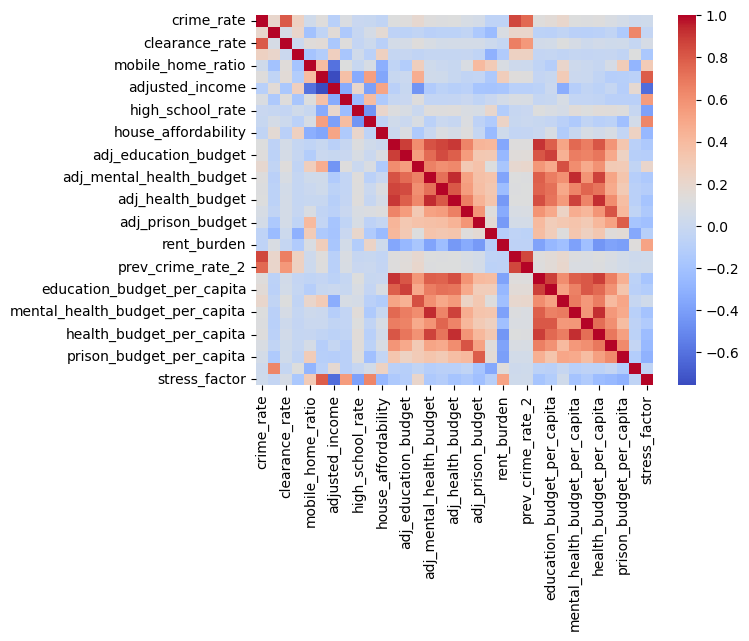

In [482]:
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.show()

### A seabon clustermap

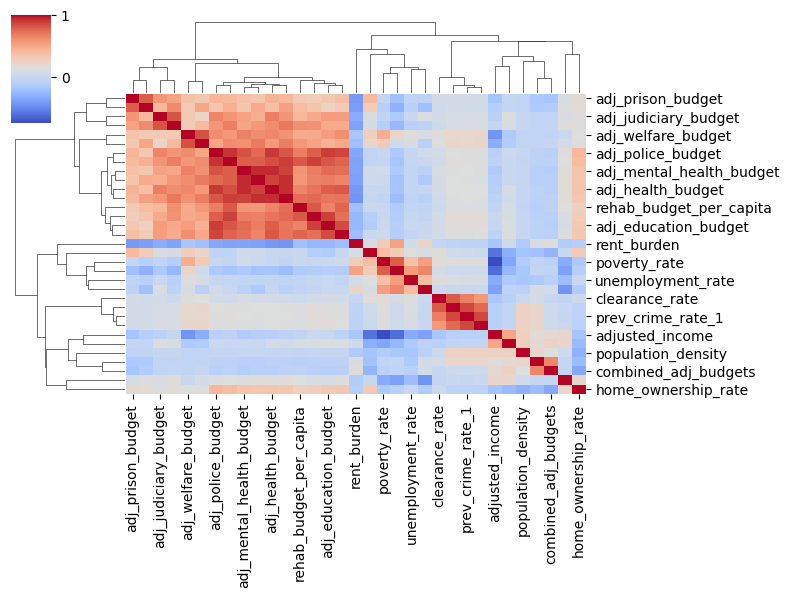

In [483]:
# Create a clustermap
sns.clustermap(correlation_matrix, cmap="coolwarm", figsize=(8, 6))
plt.show()

### A network graph visualizing the correlation 

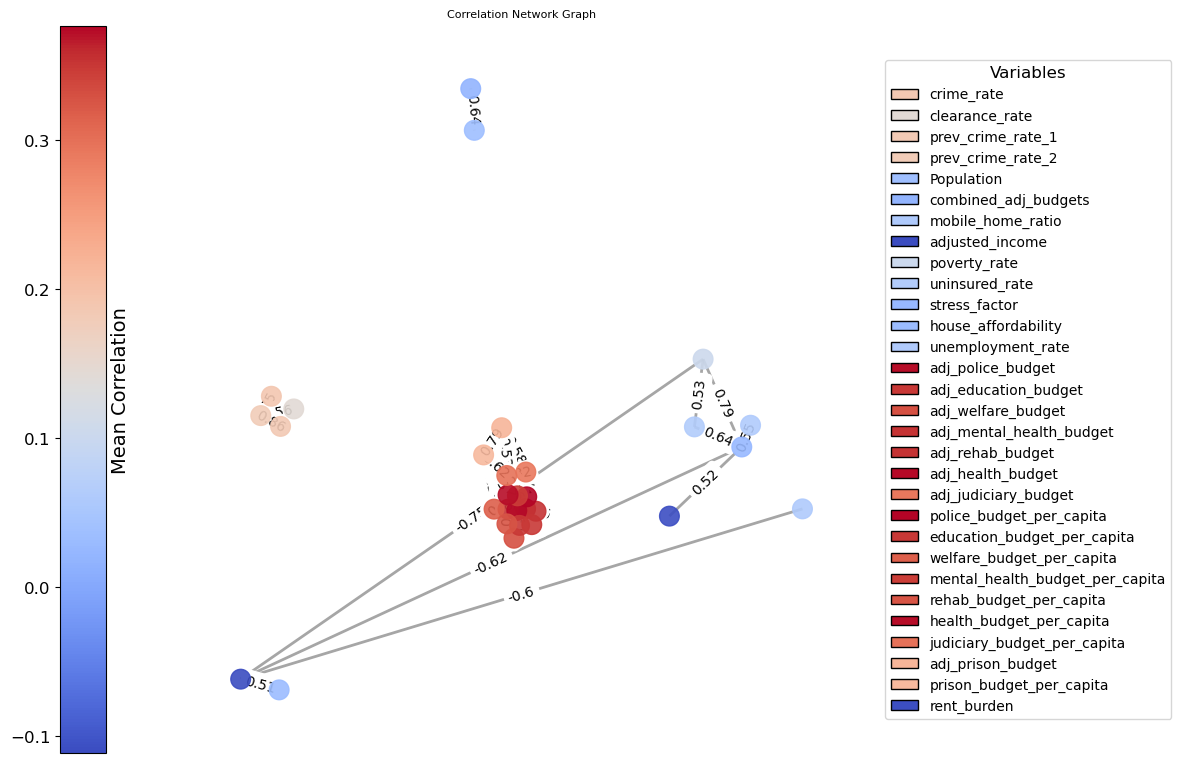

In [484]:
# Create a network graph
G = nx.Graph()

# Add nodes and edges based on correlation threshold
threshold = 0.5
for i in correlation_matrix.columns:
    for j in correlation_matrix.index:
        if i != j and abs(correlation_matrix.loc[i, j]) > threshold:
            # Add weighted edges
            G.add_edge(i, j, weight=correlation_matrix.loc[i, j])

# Filter the node_colors to include only the nodes present in the graph
graph_nodes = list(G.nodes)
node_colors = correlation_matrix.loc[graph_nodes, graph_nodes].mean(
    axis=0
)  # Compute mean only for graph nodes
norm = mcolors.Normalize(
    vmin=node_colors.min(), vmax=node_colors.max()
)  # Normalize for color mapping
cmap = plt.cm.coolwarm  # Colormap for the nodes
node_colors_mapped = [
    cmap(norm(value)) for value in node_colors
]  # Map values to colors

# Layout for nodes
pos = nx.spring_layout(G, seed=42)  # Force-directed layout for better spacing

# Start the plot with customized figure layout
fig = plt.figure(figsize=(12, 8))
grid = fig.add_gridspec(
    1, 3, width_ratios=[0.05, 0.75, 0.2]
)  # Adjust width_ratios for a thinner cbar
ax_cbar = fig.add_subplot(grid[0])  # Color bar on the left
ax_main = fig.add_subplot(grid[1])  # Main graph in the center
ax_legend = fig.add_subplot(grid[2])  # Legend on the right

# Draw the main graph
nx.draw_networkx_nodes(
    G, pos, node_size=200, node_color=node_colors_mapped, alpha=0.9, ax=ax_main
)
nx.draw_networkx_edges(G, pos, width=2, edge_color="gray", alpha=0.7, ax=ax_main)
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={(u, v): round(d["weight"], 2) for u, v, d in G.edges(data=True)},
    font_size=10,
    font_color="black",
    ax=ax_main,
)
ax_main.set_title(
    "Correlation Network Graph",
    fontsize=8,
)
ax_main.axis("off")  # Hide axis for the graph

# Add resized color bar with larger fonts
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax_cbar, orientation="vertical")
cbar.ax.tick_params(labelsize=12)  # Increase tick label font size
cbar.set_label("Mean Correlation", fontsize=14)  # Increase color bar label font size
ax_cbar.yaxis.tick_left()

# Create a legend on the right
ax_legend.axis("off")  # Hide the axes for the legend panel
legend_elements = [
    Patch(facecolor=cmap(norm(value)), edgecolor="black", label=f"{node}")
    for node, value in zip(graph_nodes, node_colors)
]
ax_legend.legend(
    handles=legend_elements,
    loc="center",
    title="Variables",
    fontsize=10,
    title_fontsize=12,
)

# Finalize the layout
plt.tight_layout()
plt.show()

In [485]:
clean_dataframe

County  Year  Population  crime_rate  clearance_rate  \
0     Alameda  1985     1185500    0.009809        0.004580   
1     Alameda  1986     1206900    0.010353        0.004615   
2     Alameda  1987     1220600    0.009588        0.005164   
3     Alameda  1988     1242300    0.008825        0.004595   
4     Alameda  1989     1261200    0.008375        0.004163   
...       ...   ...         ...         ...             ...   
2257     Yuba  2019       79619    0.004095        0.001683   
2258     Yuba  2020       81178    0.004977        0.001983   
2259     Yuba  2021       82091    0.004312        0.001815   
2260     Yuba  2022       82563    0.003379        0.001466   
2261     Yuba  2023       83405    0.004005        0.001463   

      population_density Category  Category_encoded  Category_Rural  \
0            1606.368564    Urban                 2               0   
1            1635.365854    Urban                 2               0   
2            1653.929539    Urban                 2               0   
3            1683.333333    Urban                 2               0   
4            1708.943089    Urban                 2               0   
...                  ...      ...               ...             ...   
2257          126.379365    Rural                 0               1   
2258          128.853968    Rural                 0               1   
2259          130.303175    Rural                 0               1   
2260          131.052381    Rural                 0               1   
2261          132.388889    Rural                 0               1   

      Category_Suburban  ...  welfare_budget_per_capita  \
0                     0  ...                 486.919719   
1                     0  ...                 486.919719   
2                     0  ...                 486.919719   
3                     0  ...                 486.919719   
4                     0  ...                 486.919719   
...                 ...  ...                        ...   
2257                  0  ...                 695.612065   
2258                  0  ...                 752.918722   
2259                  0  ...                 752.387765   
2260                  0  ...                 784.468854   
2261                  0  ...                 920.241424   

      mental_health_budget_per_capita  rehab_budget_per_capita  \
0                          183.553896                30.549916   
1                          183.553896                30.549916   
2                          183.553896                30.549916   
3                          183.553896                30.549916   
4                          183.553896                30.549916   
...                               ...                      ...   
2257                       183.553896                30.549916   
2258                       183.553896                30.549916   
2259                       183.553896                30.549916   
2260                       183.553896                30.549916   
2261                       183.553896                30.549916   

      health_budget_per_capita  judiciary_budget_per_capita  \
0                   362.370509                   129.526320   
1                   362.370509                   129.526320   
2                   362.370509                   129.526320   
3                   362.370509                   129.526320   
4                   362.370509                   129.526320   
...                        ...                          ...   
2257                 92.845765                    97.991535   
2258                 99.150225                   103.327342   
2259                109.459746                    96.746623   
2260                 98.960176                    97.368240   
2261                123.497404                   108.396235   

      prison_budget_per_capita  combined_adj_budgets  stress_factor  \
0                   180.810273          2.073927e+08       17.57947

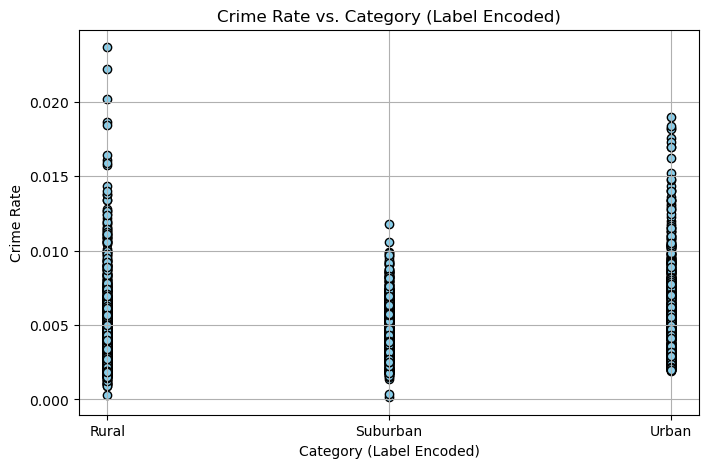

In [486]:
# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(
    clean_dataframe["Category_encoded"],
    clean_dataframe["crime_rate"],
    color="skyblue",
    edgecolor="black",
)
plt.xticks([0, 1, 2], ["Rural", "Suburban", "Urban"])
plt.xlabel("Category (Label Encoded)")
plt.ylabel("Crime Rate")
plt.title("Crime Rate vs. Category (Label Encoded)")
plt.grid(True)
plt.show()

C:\Users\leoaf\AppData\Local\Temp\ipykernel_19888\3784812643.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




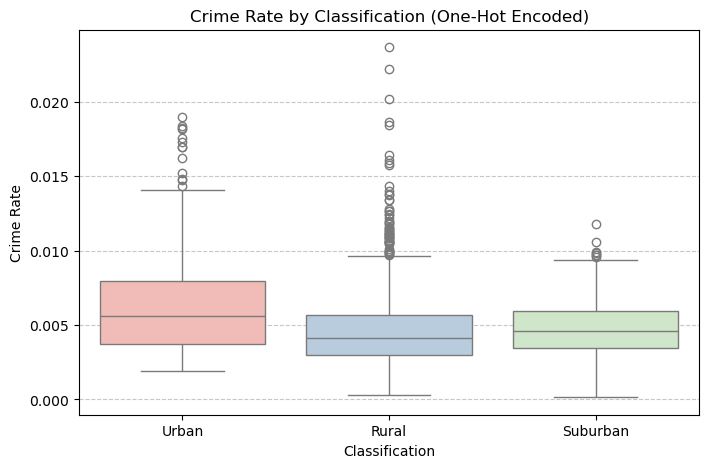

In [487]:
# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x="Category", y="crime_rate", data=clean_dataframe, palette="Pastel1")
plt.title("Crime Rate by Classification (One-Hot Encoded)")
plt.xlabel("Classification")
plt.ylabel("Crime Rate")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

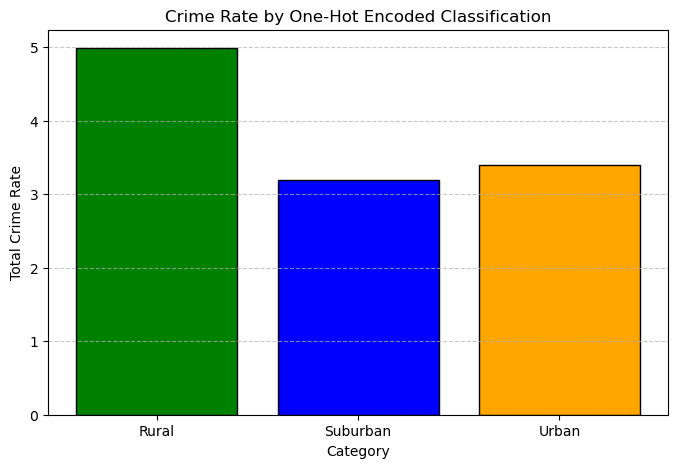

In [488]:
# Summing crime rates for each type
crime_rate_by_type = {
    "Rural": clean_dataframe["Category_Rural"].dot(clean_dataframe["crime_rate"]),
    "Suburban": clean_dataframe["Category_Suburban"].dot(clean_dataframe["crime_rate"]),
    "Urban": clean_dataframe["Category_Urban"].dot(clean_dataframe["crime_rate"]),
}

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(
    crime_rate_by_type.keys(),
    crime_rate_by_type.values(),
    color=["green", "blue", "orange"],
    edgecolor="black",
)
plt.xlabel("Category")
plt.ylabel("Total Crime Rate")
plt.title("Crime Rate by One-Hot Encoded Classification")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [489]:
# List of features for dropdown selection
feature_options = list(clean_dataframe.columns)

# Create dropdown selections for x and y axes
x_feature_dropdown = alt.binding_select(
    options=feature_options, name="Select Feature X:"
)
y_feature_dropdown = alt.binding_select(
    options=feature_options, name="Select  Feature Y:"
)
x_feature = alt.param(
    name="x_feature", bind=x_feature_dropdown, value="Population"
)  # Default X: Population
y_feature = alt.param(
    name="y_feature", bind=y_feature_dropdown, value="crime_rate"
)  # Default Y: CrimeRate

# Interactive scatter plot
scatter = (
    alt.Chart(clean_dataframe)
    .transform_calculate(
        x_value=f"datum[x_feature]",  # Dynamically calculate x-axis values
        y_value=f"datum[y_feature]",  # Dynamically calculate y-axis values
    )
    .mark_circle(size=60)
    .encode(
        x=alt.X("x_value:Q", title="X Feature"),  # Use dynamically calculated x_value
        y=alt.Y("y_value:Q", title="Y Feature"),  # Use dynamically calculated y_value
        color="Category:N",  # Color encoding by classification
        tooltip=["Population", "crime_rate", "high_school_rate", "Category"],
    )
    .add_params(x_feature, y_feature)
    .properties(width=600, height=400, title="Interactive Pairwise Scatter Plot")
    .interactive()
)

scatter

alt.Chart(...)

### Split data into train and test data

In [490]:
X = final_dataframe[features]  # Independent varaibles
y = final_dataframe["crime_rate"]  # Dependent variable

# Split data
train_data, test_data = train_test_split(
    final_dataframe, test_size=0.2, random_state=42
)
X_train, y_train = train_data[features], train_data["crime_rate"]
X_test, y_test = test_data[features], test_data["crime_rate"]

#### Ensure split ratio is accurate.

In [491]:
# Calculate the sizes
total_rows = len(final_dataframe)
train_size = len(X_train)
test_size = len(X_test)

# Check if the split is correct
print(f"Total rows: {total_rows}")
print(f"Training rows: {train_size} ({(train_size / total_rows) * 100:.2f}%)")
print(f"Testing rows: {test_size} ({(test_size / total_rows) * 100:.2f}%)")

# Verify the split
expected_test_size = total_rows * 0.2  # 20% of total rows
print(f"Expected test size: {expected_test_size:.0f}")
print(
    f"Is the split ratio correct? {'Yes' if abs(test_size - expected_test_size) < 1 else 'No'}"
)

Total rows: 2262
Training rows: 1809 (79.97%)
Testing rows: 453 (20.03%)
Expected test size: 452
Is the split ratio correct? Yes


#### Exploratory data analysis (EDA)

In [492]:
X_train.columns

Index(['Population', 'clearance_rate', 'population_density',
       'mobile_home_ratio', 'poverty_rate', 'adjusted_income',
       'unemployment_rate', 'high_school_rate', 'uninsured_rate',
       'house_affordability', 'adj_police_budget', 'adj_education_budget',
       'adj_welfare_budget', 'adj_mental_health_budget', 'adj_rehab_budget',
       'adj_health_budget', 'adj_judiciary_budget', 'adj_prison_budget',
       'home_ownership_rate', 'rent_burden', 'prev_crime_rate_1',
       'prev_crime_rate_2', 'police_budget_per_capita',
       'education_budget_per_capita', 'welfare_budget_per_capita',
       'mental_health_budget_per_capita', 'rehab_budget_per_capita',
       'health_budget_per_capita', 'judiciary_budget_per_capita',
       'prison_budget_per_capita', 'combined_adj_budgets', 'stress_factor'],
      dtype='object')

### Regression Analysis

In [ ]:
# A function to fit models
def fit_models(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.DataFrame,
    y_test: pd.DataFrame,
    **models
) -> tuple[dict, dict[dict,], dict[dict,]]:
    """
    Fit nodels an compute compute their root mean square errors,
    mean square errors and r2 socres

    Parameters:
    X_train(pd.DataFrame): features-train data
    X_test(pd.DataFrame): features-test data
    y_train(pd.DataFrame): target-train data
    y_test(pd.DataFrame): target-test data
    models: A dictionary of models

    Returns:
    dict: A tuple (dict, dict, dict).
    - First dict: The fitted models
    - Second dict: A dictionary of dictionaries.
        Each dictionary contains two lists [root mean square errors, mean square errors, r2 socres].
        One for train data and the other for test data.
    - Third dict: A dictionary of dictionaries.
        Each dictionary contains two predicted values.
        One for train data and the other for test data.
    """

    model_stats = {}
    fitted_models = {}
    predicted_values = {}

    for key, model in models.items():
        # Fit the models to the training data
        model.fit(X_train, y_train)

        # Find the model predictions on the training set
        train_preds = model.predict(X_train)

        # Find the model predictions on the test set
        test_preds = model.predict(X_test)

        # Find the mse on the training set
        train_mse = mean_squared_error(y_train, train_preds)
        train_rmse = root_mean_squared_error(y_train, train_preds)
        train_r2score = r2_score(y_train, train_preds)

        # Find the mse on the test set
        test_mse = mean_squared_error(y_test, test_preds)
        test_rmse = root_mean_squared_error(y_test, test_preds)
        test_r2score = r2_score(y_test, test_preds)

        fitted_models[key] = model
        model_stats[key] = {
            "train": [train_mse, train_rmse, train_r2score],
            "test": [test_mse, test_rmse, test_r2score],
        }
        predicted_values[key] = {"train": train_preds, "test": test_preds}

    return fitted_models, model_stats, predicted_values

In [494]:
# Regression models to train
models = {
    "mlr": LinearRegression(),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_models, models_stats, predicted_values = fit_models(
    X_train, X_test, y_train, y_test, **models
)

# Using pretty table
table = PrettyTable()
table.field_names = ["Model", "Type", "MSE", "RMSE", "r2 Score"]

for key, stat in models_stats.items():
    table.add_rows(
        [
            [key, "train data", stat["train"][0], stat["train"][1], stat["train"][2]],
            ["", "test data", stat["test"][0], stat["test"][1], stat["test"][2]],
        ],
        divider=True,
    )
table.set_style(TableStyle.DOUBLE_BORDER)
print(table)

╔═══════════════╦════════════╦════════════════════════╦════════════════════════╦════════════════════╗
║     Model     ║    Type    ║          MSE           ║          RMSE          ║      r2 Score      ║
╠═══════════════╬════════════╬════════════════════════╬════════════════════════╬════════════════════╣
║      mlr      ║ train data ║ 1.076696341050509e-06  ║ 0.0010376397934979695  ║ 0.8474959988915626 ║
║               ║ test data  ║ 7.171203842747107e-07  ║ 0.0008468296075803624  ║ 0.8848367954793299 ║
╠═══════════════╬════════════╬════════════════════════╬════════════════════════╬════════════════════╣
║      xgb      ║ train data ║ 2.9629766469887637e-07 ║ 0.0005443323109083976  ║ 0.9580321975074446 ║
║               ║ test data  ║ 7.797724287029206e-07  ║ 0.0008830472403574571  ║ 0.8747754301014354 ║
╠═══════════════╬════════════╬════════════════════════╬════════════════════════╬════════════════════╣
║     ridge     ║ train data ║ 1.0767539470987286e-06 ║ 0.0010376675513374834  ║ 0

### Observation from the table above
- From the table above, it seems XGBRegressor and RandomForestRegressor are performing better.
- We will use cross validations to confirm this performance ? 


## Visualize Linear regression model results 
1. Visualize coefficient importance for  linear regression
2. Visualize predicted vs true values for linear regression
3. Visualize residuals for linear regression

#### Visualize coefficient importance for  linear regression

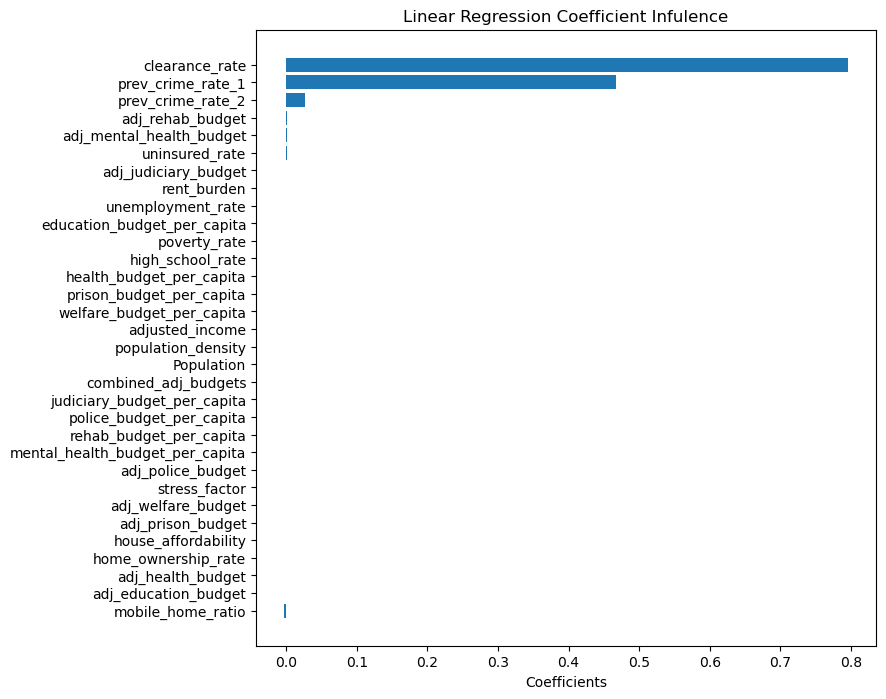

In [521]:
coeffs_mlr = fitted_models["mlr"].coef_
features = list(X_train.columns)
sorted_indices_mlr = np.argsort(coeffs_mlr)
plt.figure(figsize=(8, 8))
plt.barh([features[i] for i in sorted_indices_mlr], coeffs_mlr[sorted_indices_mlr])
plt.title("Linear Regression Coefficient Infulence")
plt.xlabel("Coefficients")
plt.show()

#### Visualize predicted vs true values for linear regression

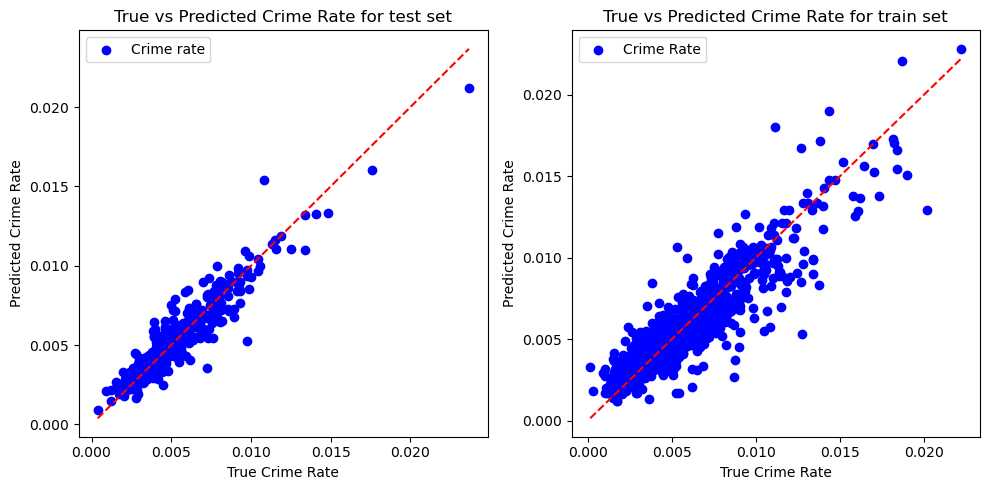

In [496]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
mlr_test_preds = predicted_values["mlr"]["test"]
mlr_train_preds = predicted_values["mlr"]["train"]

# First subplot
axes[0].scatter(y_test, mlr_test_preds, color="blue", label="Crime rate")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
axes[0].set_title("True vs Predicted Crime Rate for test set")
axes[0].set_xlabel("True Crime Rate")
axes[0].set_ylabel("Predicted Crime Rate")
axes[0].legend()

# Second subplot
axes[1].scatter(y_train, mlr_train_preds, color="blue", label="Crime Rate")
axes[1].plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], "--", color="red"
)
axes[1].set_title("True vs Predicted Crime Rate for train set")
axes[1].set_xlabel("True Crime Rate")
axes[1].set_ylabel("Predicted Crime Rate")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualize residuals for linear regression

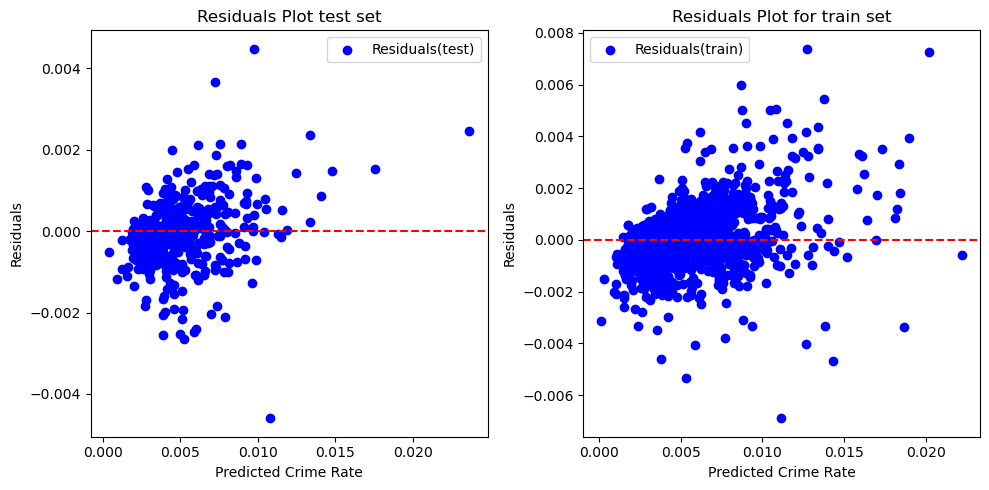

In [497]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
mlr_test_residuals = y_test - mlr_test_preds
axes[0].scatter(y_test, mlr_test_residuals, color="blue", label="Residuals(test)")
axes[0].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[0].set_title("Residuals Plot test set")
axes[0].set_xlabel("Predicted Crime Rate")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Second subplot
mlr_train_residuals = y_train - mlr_train_preds
axes[1].scatter(y_train, mlr_train_residuals, color="blue", label="Residuals(train)")
axes[1].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[1].set_title("Residuals Plot for train set")
axes[1].set_xlabel("Predicted Crime Rate")
axes[1].set_ylabel("Residuals")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Visualize XGB regression model results 
1. Visualize feature impotance
2. Visualize predicted vs true values
3. Visualize the residuals

#### Visualize feature impotance for XGBoost

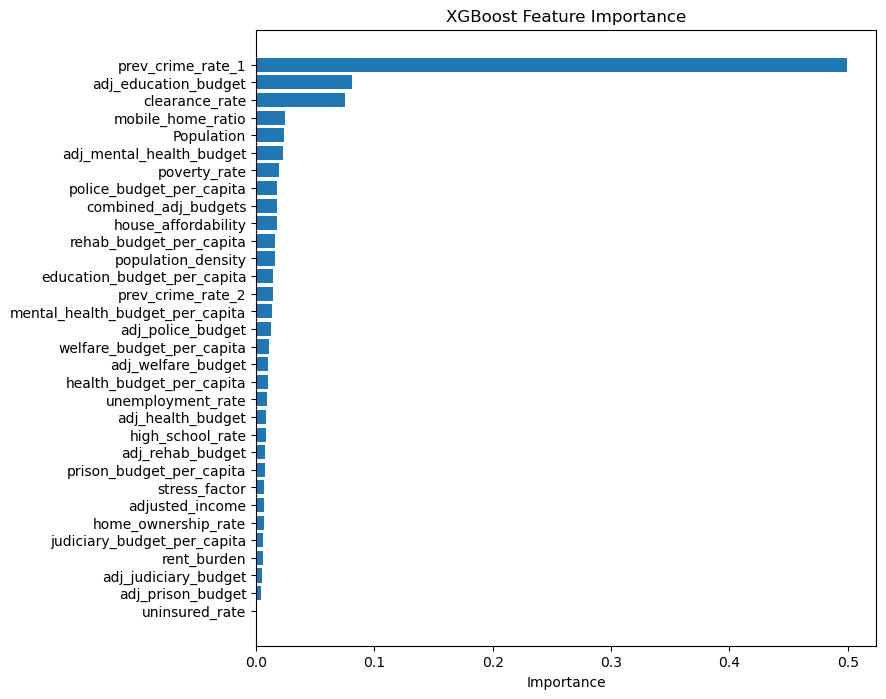

In [520]:
importance_xgb = fitted_models["xgb"].feature_importances_
sorted_indices_xgb = np.argsort(importance_xgb)
plt.figure(figsize=(8, 8))
plt.barh([features[i] for i in sorted_indices_xgb], importance_xgb[sorted_indices_xgb])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.show()

#### Visualize predicted vs true values XGBoost

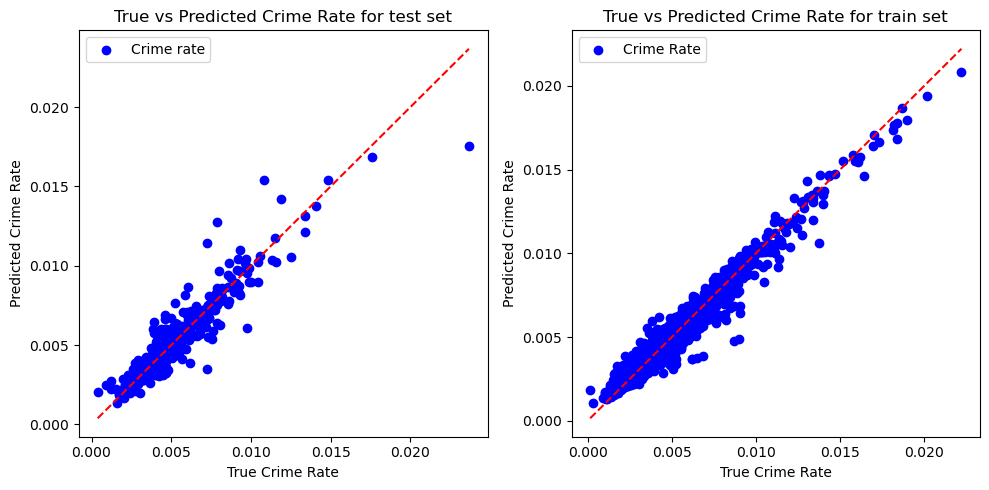

In [499]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
xgb_test_preds = predicted_values["xgb"]["test"]
xgb_train_preds = predicted_values["xgb"]["train"]

# First subplot
axes[0].scatter(y_test, xgb_test_preds, color="blue", label="Crime rate")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
axes[0].set_title("True vs Predicted Crime Rate for test set")
axes[0].set_xlabel("True Crime Rate")
axes[0].set_ylabel("Predicted Crime Rate")
axes[0].legend()

# Second subplot
axes[1].scatter(y_train, xgb_train_preds, color="blue", label="Crime Rate")
axes[1].plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], "--", color="red"
)
axes[1].set_title("True vs Predicted Crime Rate for train set")
axes[1].set_xlabel("True Crime Rate")
axes[1].set_ylabel("Predicted Crime Rate")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualize the residuals XGBoost

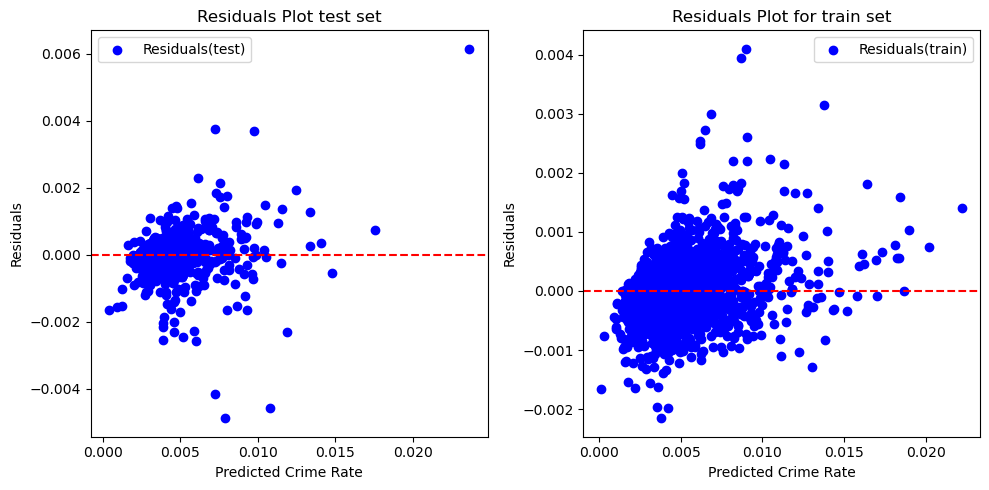

In [500]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
xgb_test_residuals = y_test - xgb_test_preds
axes[0].scatter(y_test, xgb_test_residuals, color="blue", label="Residuals(test)")
axes[0].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[0].set_title("Residuals Plot test set")
axes[0].set_xlabel("Predicted Crime Rate")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Second subplot
xgb_train_residuals = y_train - xgb_train_preds
axes[1].scatter(y_train, xgb_train_residuals, color="blue", label="Residuals(train)")
axes[1].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[1].set_title("Residuals Plot for train set")
axes[1].set_xlabel("Predicted Crime Rate")
axes[1].set_ylabel("Residuals")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Visualize Ridge regression model results 
1. Visualize feature impotance
2. Visualize predicted vs true values
3. Visualize the residuals

#### Visualize coefficient importance for Ridge regression

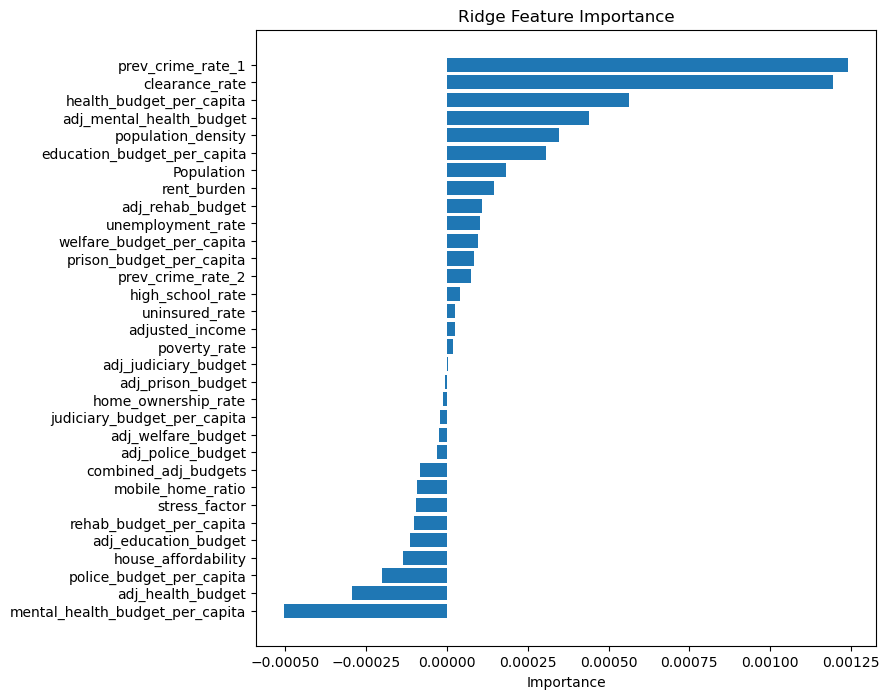

In [519]:
ridge_model = fitted_models["ridge"].named_steps["ridge"]
coeffs_ridge = ridge_model.coef_
sorted_indices_ridge = np.argsort(coeffs_ridge)
plt.figure(figsize=(8, 8))
plt.barh(
    [features[i] for i in sorted_indices_ridge], coeffs_ridge[sorted_indices_ridge]
)
plt.title("Ridge Feature Importance")
plt.xlabel("Importance")
plt.show()

#### Visualize predicted vs true values

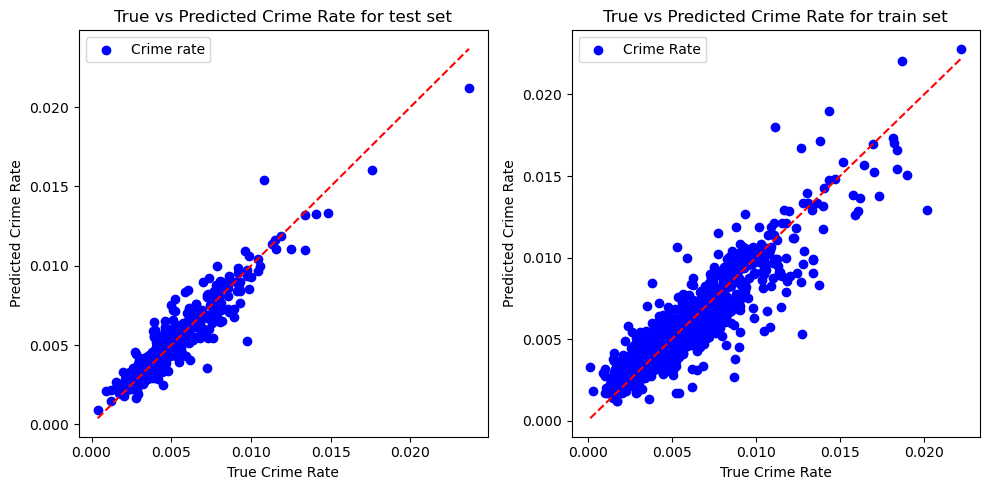

In [502]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ridge_test_preds = predicted_values["ridge"]["test"]
ridge_train_preds = predicted_values["ridge"]["train"]

# First subplot
axes[0].scatter(y_test, ridge_test_preds, color="blue", label="Crime rate")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
axes[0].set_title("True vs Predicted Crime Rate for test set")
axes[0].set_xlabel("True Crime Rate")
axes[0].set_ylabel("Predicted Crime Rate")
axes[0].legend()

# Second subplot
axes[1].scatter(y_train, ridge_train_preds, color="blue", label="Crime Rate")
axes[1].plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], "--", color="red"
)
axes[1].set_title("True vs Predicted Crime Rate for train set")
axes[1].set_xlabel("True Crime Rate")
axes[1].set_ylabel("Predicted Crime Rate")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualize the residuals

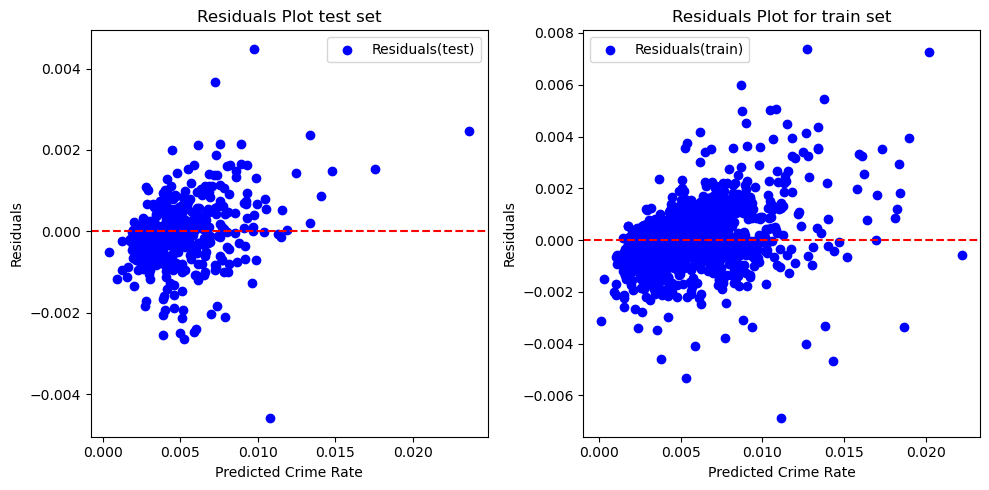

In [503]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
ridge_test_residuals = y_test - ridge_test_preds
axes[0].scatter(y_test, ridge_test_residuals, color="blue", label="Residuals(test)")
axes[0].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[0].set_title("Residuals Plot test set")
axes[0].set_xlabel("Predicted Crime Rate")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Second subplot
ridge_train_residuals = y_train - ridge_train_preds
axes[1].scatter(y_train, ridge_train_residuals, color="blue", label="Residuals(train)")
axes[1].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[1].set_title("Residuals Plot for train set")
axes[1].set_xlabel("Predicted Crime Rate")
axes[1].set_ylabel("Residuals")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Visualize RandomForest regression model results 
1. Visualize feature impotance
2. Visualize predicted vs true values
3. Visualize the residuals

#### Visualize coefficient importance for random forest

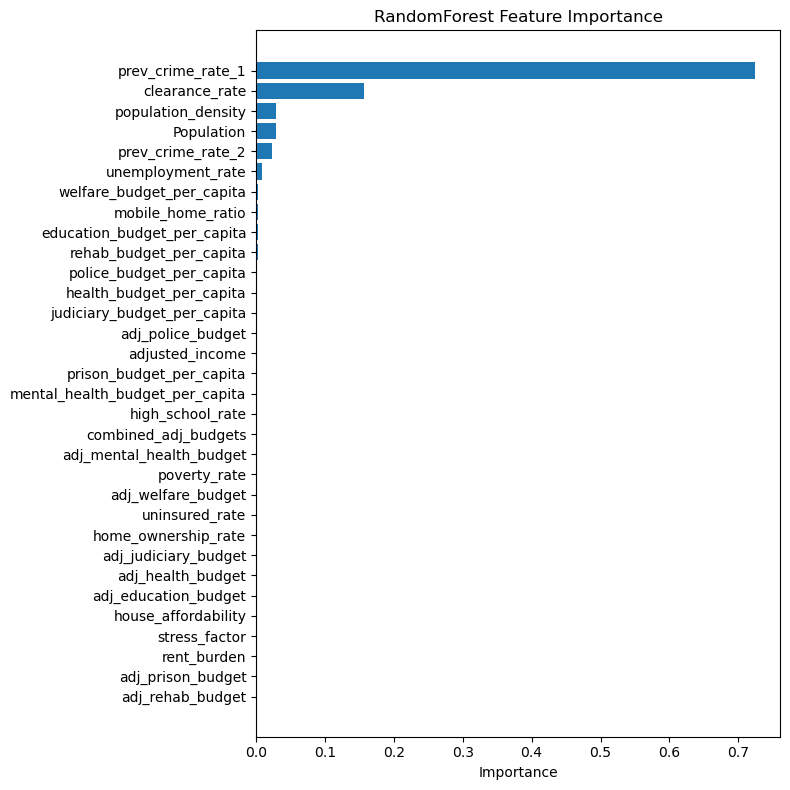

In [518]:
randonforest_model = fitted_models["random_forest"].named_steps["randomforest"]
importance_randonforest = randonforest_model.feature_importances_
sorted_indices_randonforest = np.argsort(importance_randonforest)
plt.figure(figsize=(8, 8))
plt.barh(
    [features[i] for i in sorted_indices_randonforest],
    importance_randonforest[sorted_indices_randonforest],
)
plt.title("RandomForest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

#### Visualize predicted vs true values for RandomForest

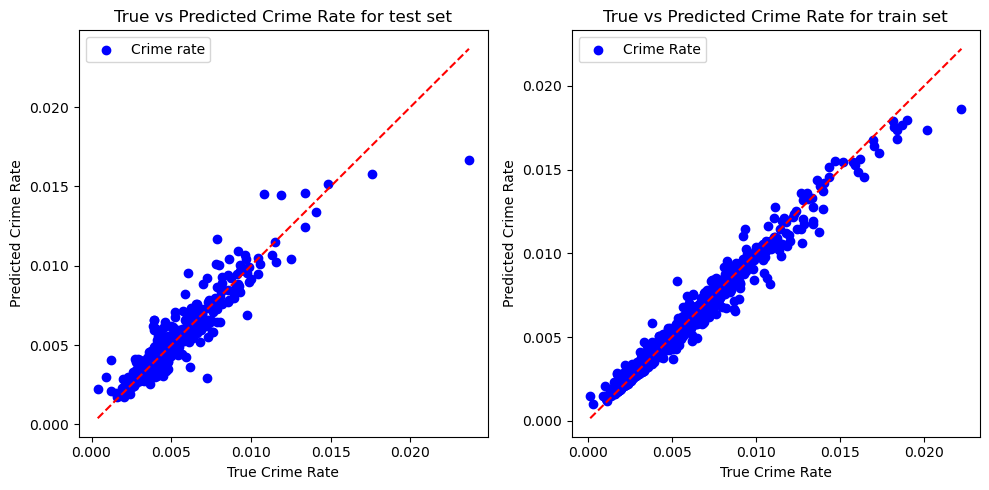

In [516]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
randomforest_test_preds = predicted_values["random_forest"]["test"]
randomforest_train_preds = predicted_values["random_forest"]["train"]

# First subplot
axes[0].scatter(y_test, randomforest_test_preds, color="blue", label="Crime rate")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
axes[0].set_title("True vs Predicted Crime Rate for test set")
axes[0].set_xlabel("True Crime Rate")
axes[0].set_ylabel("Predicted Crime Rate")
axes[0].legend()

# Second subplot
axes[1].scatter(y_train, randomforest_train_preds, color="blue", label="Crime Rate")
axes[1].plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], "--", color="red"
)
axes[1].set_title("True vs Predicted Crime Rate for train set")
axes[1].set_xlabel("True Crime Rate")
axes[1].set_ylabel("Predicted Crime Rate")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualize the residuals

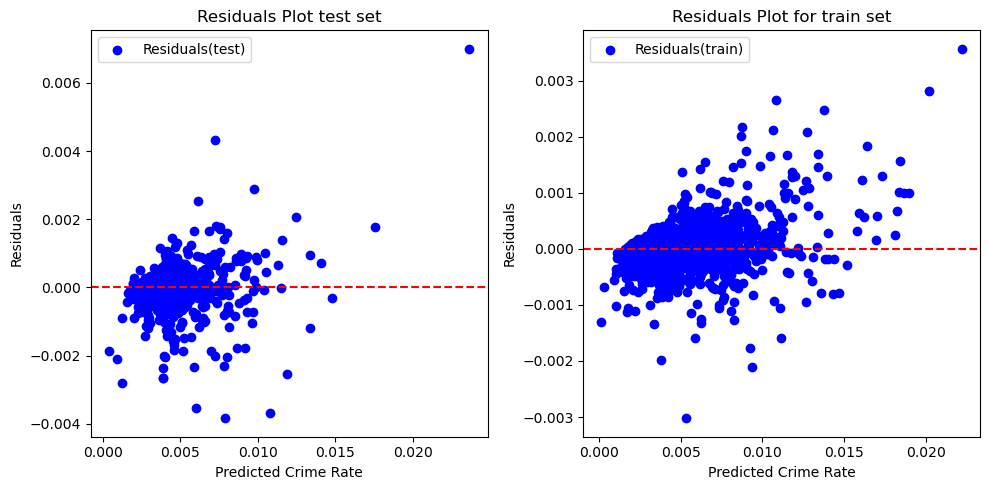

In [506]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
randomforest_test_residuals = y_test - randomforest_test_preds
axes[0].scatter(
    y_test, randomforest_test_residuals, color="blue", label="Residuals(test)"
)
axes[0].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[0].set_title("Residuals Plot test set")
axes[0].set_xlabel("Predicted Crime Rate")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Second subplot
randomforest_train_residuals = y_train - randomforest_train_preds
axes[1].scatter(
    y_train, randomforest_train_residuals, color="blue", label="Residuals(train)"
)
axes[1].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[1].set_title("Residuals Plot for train set")
axes[1].set_xlabel("Predicted Crime Rate")
axes[1].set_ylabel("Residuals")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Observations from the visuals.
From the visuals, it appears that the performance of the models  ranks as follows
1. Randonforest Regressor
2. XGBoost Regressor
3. Ridge Regressor
4. Linear Regressor

#### Principal Component Analysis
1. Standardise the training data: give all variables equal weight.
    - Use StandardScaler from sklearn to scale your data to have a mean of 0 and standard deviation of 
    

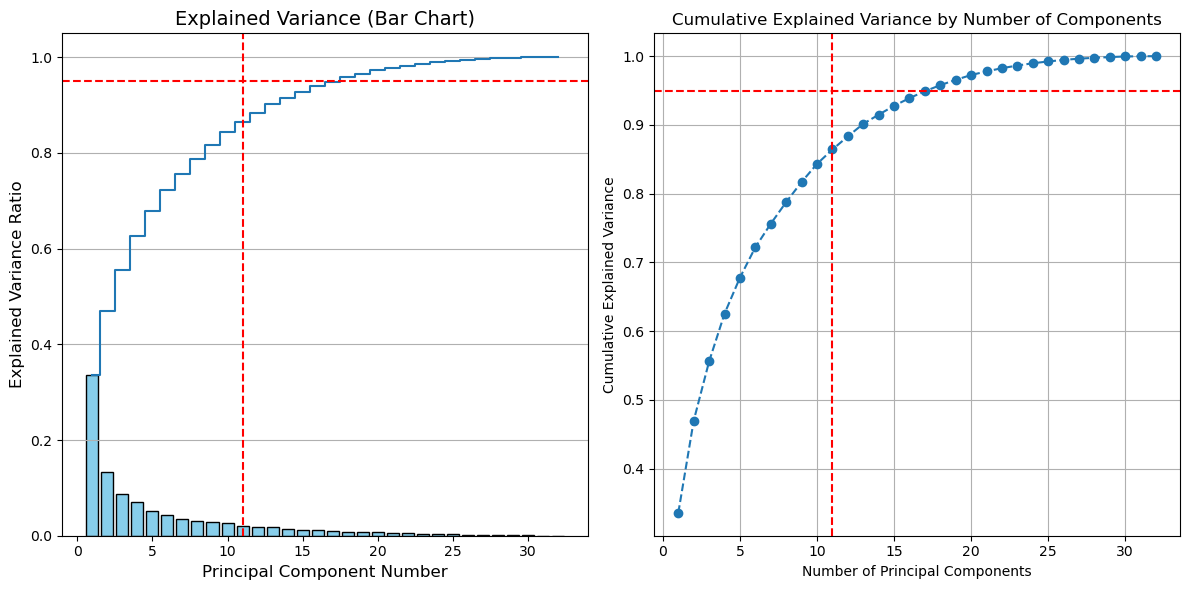

Number of components to retain 90% variance: 13
Original shape: (1809, 32)
Reduced shape: (1809, 13)


In [507]:
# Standardise the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA to the training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Explain variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Subplot 1: Bar chart for explained variance ratio
axes[0].bar(
    range(1, len(explained_variance) + 1),
    explained_variance,
    color="skyblue",
    edgecolor="black",
)
axes[0].step(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    where="mid",
    label="Cumulative Variance",
)
axes[0].axhline(y=0.95, color="red", linestyle="--", label="95% Threshold")
axes[0].axvline(x=11, color="red", linestyle="--", label="Retained 11 PCs")
axes[0].set_xlabel("Principal Component Number", fontsize=12)
axes[0].set_ylabel("Explained Variance Ratio", fontsize=12)
axes[0].set_title("Explained Variance (Bar Chart)", fontsize=14)
axes[0].grid(axis="y")

axes[1].plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
)
axes[1].axhline(y=0.95, color="red", linestyle="--", label="95% Threshold")
axes[1].axvline(x=11, color="red", linestyle="--", label="Retained 11 PCs")
axes[1].set_xlabel("Number of Principal Components")
axes[1].set_ylabel("Cumulative Explained Variance")
axes[1].set_title("Cumulative Explained Variance by Number of Components")
axes[1].grid()
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Step 4: Decide the number of components to keep
# For example, keep enough components to explain 90% of variance
n_components = (
    np.argmax(cumulative_variance >= 0.9) + 1
)  # First PC where cumulative >= 90%
print(f"Number of components to retain 90% variance: {n_components}")

# Step 5: Apply PCA again with the chosen number of components
pca_reduced = PCA(n_components=n_components)
X_train_reduced = pca_reduced.fit_transform(X_train_scaled)

# Show shape of reduced data
print(f"Original shape: {X_train_scaled.shape}")
print(f"Reduced shape: {X_train_reduced.shape}")

### Interpretaion of the scree plot

- Components to the left of the elbow are important — they explain significant variance.

- Components after the elbow contribute little and may not be worth retaining.

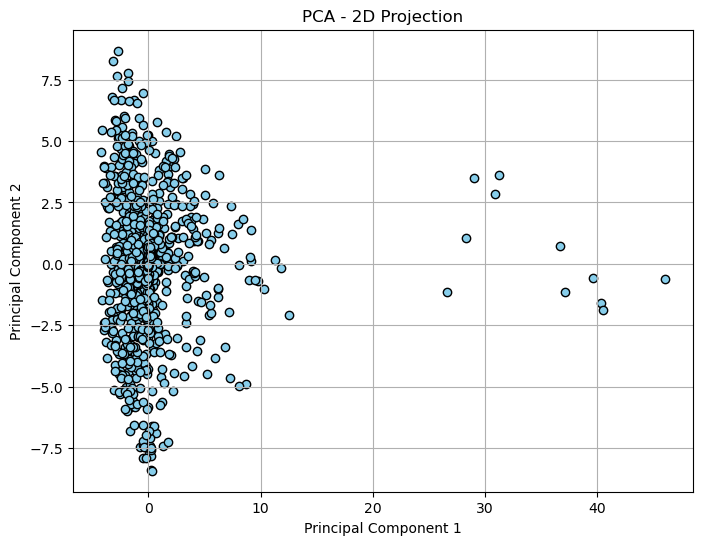

In [508]:
# Visualize the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_reduced[:, 0], X_train_reduced[:, 1], c="skyblue", edgecolor="black"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - 2D Projection")
plt.grid()
plt.show()

In [509]:
# Get the PCA loadings
loadings = pd.DataFrame(
    pca_reduced.components_.T,
    columns=[f"PC{i+1}" for i in range(n_components)],
    index=X_train.columns,
)

loadings

PC1       PC2       PC3       PC4  \
Population                      -0.036264 -0.071882  0.367007 -0.111412   
clearance_rate                   0.026923  0.125509  0.293366  0.363521   
population_density              -0.010490 -0.134939  0.278510  0.052710   
mobile_home_ratio                0.026108  0.267849 -0.210533  0.291425   
poverty_rate                    -0.004328  0.425840  0.066650 -0.077163   
adjusted_income                 -0.037352 -0.414583  0.092559 -0.070573   
unemployment_rate               -0.011397  0.270801  0.019917 -0.090251   
high_school_rate                 0.056587 -0.194958 -0.074177  0.141102   
uninsured_rate                  -0.032287  0.280168  0.077968 -0.260422   
house_affordability              0.004186 -0.240406  0.171560 -0.177297   
adj_police_budget                0.277493 -0.001535  0.019274 -0.116396   
adj_education_budget             0.249262 -0.009142  0.065074 -0.158498   
adj_welfare_budget               0.209148  0.215688  0.082047 -0.052949   
adj_mental_health_budget         0.268448  0.024178  0.001320 -0.063577   
adj_rehab_budget                 0.248770  0.010405  0.038436 -0.129843   
adj_health_budget                0.281979 -0.006429  0.011990 -0.084008   
adj_judiciary_budget             0.204514 -0.023612 -0.008828  0.018499   
adj_prison_budget                0.173885  0.005250 -0.145304  0.273911   
home_ownership_rate              0.106693  0.034143 -0.281204  0.108856   
rent_burden                     -0.159454  0.151239  0.057737 -0.168534   
prev_crime_rate_1                0.057611  0.086302  0.427302  0.353455   
prev_crime_rate_2                0.056225  0.081893  0.420698  0.328764   
police_budget_per_capita         0.281814 -0.014442  0.016611 -0.095697   
education_budget_per_capita      0.247090 -0.018097  0.061250 -0.135567   
welfare_budget_per_capita        0.215738  0.136625  0.064037  0.020959   
mental_health_budget_per_capita  0.264799  0.000778 -0.013082 -0.022274   
rehab_budget_per_capita          0.228281 -0.007696  0.024520 -0.109167   
health_budget_per_capita         0.284097 -0.027968  0.001150 -0.049180   
judiciary_budget_per_capita      0.223422 -0.068446 -0.023092  0.061479   
prison_budget_per_capita         0.179814 -0.040448 -0.139201  0.278400   
combined_adj_budgets            -0.039959 -0.092997  0.309137 -0.226319   
stress_factor                   -0.076594  0.408834  0.049178 -0.190009   

                                      PC5       PC6       PC7       PC8  \
Population                       0.199454  0.242687 -0.331924 -0.319171   
clearance_rate                  -0.135631 -0.144316 -0.148995 -0.053319   
population_density               0.079659  0.014017  0.428199  0.221445   
mobile_home_ratio                0.119520  0.161345 -0.202701  0.164673   
poverty_rate                     0.074443  0.116095  0.096671  0.104551   
adjusted_income                 -0.069132 -0.110632  0.104492  0.051137   
unemployment_rate               -0.003667 -0.265841  0.104278 -0.020683   
high_school_rate                -0.165000  0.226628 -0.323157  0.280831   
uninsured_rate                   0.236351 -0.323283 -0.053844 -0.060421   
house_affordability              0.121765 -0.067522 -0.093987  0.462473   
adj_police_budget               -0.084364 -0.118572 -0.064495 -0.124407   
adj_education_budget            -0.162260 -0.160231 -0.065003  0.066262   
adj_welfare_budget              -0.014875  0.298755  0.138833  0.057217   
adj_mental_health_budget        -0.103838  0.097307  0.092548 -0.163653   
adj_rehab_budget                -0.105909 -0.059984 -0.109597  0.151106   
adj_health_budget               -0.014884 -0.031047  0.030304 -0.137978   
adj_judiciary_budget             0.334025 -0.321730 -0.184962 -0.015747   
adj_prison_budget                0.387293 -0.070517 -0.051926  0.068703   
home_ownership_rate             -0.353603 -0.065882 -0.347036 -0.218593   
rent_burden                     -0.127960  0.136124 -0.351253 

### Scree and biplots
### Comparing principal components 1 & 2

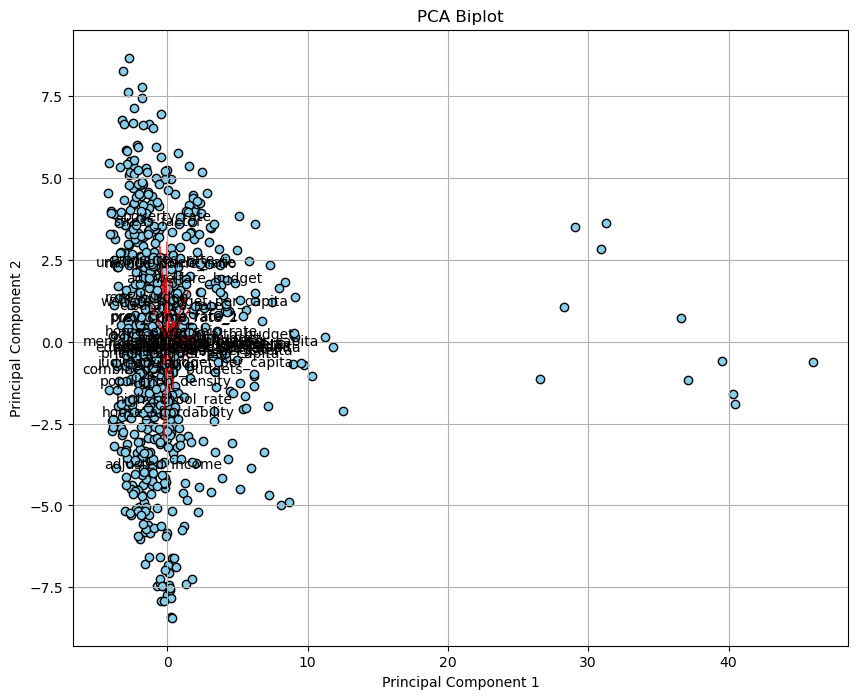

In [510]:
# Get feature loadings

# Plot biplot
plt.figure(figsize=(10, 8))

# Scatter plot of PCA scores (observations)
plt.scatter(
    X_train_reduced[:, 0], X_train_reduced[:, 1], c="skyblue", edgecolor="black"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Biplot")

# Add arrows for feature loadings (scaled for visibility)
scale_factor = 7
for i, feature in enumerate(X_train.columns):
    plt.arrow(
        0,
        0,
        loadings["PC1"].iloc[i] * scale_factor,
        loadings[f"PC2"].iloc[i] * scale_factor,
        color="red",
        alpha=0.7,
        head_width=0.05,
    )
    plt.text(
        loadings["PC1"].iloc[i] * (scale_factor + 2),
        loadings["PC2"].iloc[i] * (scale_factor + 2),
        feature,
        color="black",
        ha="center",
        va="center",
    )

plt.grid()
plt.show()

In [511]:
import numpy as np
import plotly.graph_objects as go

# `loadings` is PCA.components_.T
scaling_factor = 2
fig = go.Figure()

# Add loadings for top 3 PCs
for i, feature in enumerate(X_train.columns):
    fig.add_trace(
        go.Scatter3d(
            x=[0, loadings["PC1"].iloc[i] * scaling_factor],
            y=[0, loadings["PC2"].iloc[i] * scaling_factor],
            z=[0, loadings["PC3"].iloc[i] * scaling_factor],
            mode="lines+text",
            line=dict(color="red", width=2),
            text=[None, feature],
            name=feature,
        )
    )

# Update the layout
fig.update_layout(
    title="Loadings for Top 3 PCs",
    scene=dict(xaxis_title="PC1(x)", yaxis_title="PC2(y)", zaxis_title="PC3(z)"),
)
fig.show()

### Cross Validatons (Incomplete)

 - Include RandomForest Regressor

In [512]:
## Make a KFold object
## remember to set a random_state and set shuffle = True
num_splits = 5
num_models = 4
kfold = KFold(num_splits, random_state=216, shuffle=True)

## This array will hold the mse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(X_train):
    ## cv training set
    X_tt, y_tt = X_train.iloc[train_index], y_train.iloc[train_index]

    ## cv holdout set
    X_ho, y_ho = X_train.iloc[test_index], y_train.iloc[test_index]

    mlr = LinearRegression()
    mlr.fit(X_tt[features], y_tt)
    rmses[0, i] = root_mean_squared_error(y_ho, mlr.predict(X_ho[features]))

    xgb_model = xgb.XGBRegressor(random_state=42)
    xgb_model.fit(X_tt[features], y_tt)
    rmses[1, i] = root_mean_squared_error(y_ho, xgb_model.predict(X_ho[features]))

    ridge_pipe = Pipeline([("scale", StandardScaler()), ("ridge", Ridge())])
    ridge_pipe.fit(X_tt[features], y_tt)
    rmses[2, i] = root_mean_squared_error(y_ho, xgb_model.predict(X_ho[features]))

    pca_pipe = Pipeline(
        [("scale", StandardScaler()), ("pca", PCA(11)), ("reg", LinearRegression())]
    )
    pca_pipe.fit(X_tt[features], y_tt)
    rmses[3, i] = root_mean_squared_error(y_ho, xgb_model.predict(X_ho[features]))

    i = i + 1

In [513]:
print(f"MLR Avg. CV MSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"XBG Avg. CV MSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"Ridge Avg. CV MSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"PCA_MLR Avg. CV MSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

MLR Avg. CV MSE: 0.001086363183204255 and STD: 9.542541596554409e-05
XBG Avg. CV MSE: 0.0011110987415328577 and STD: 6.711313871202127e-05
Ridge Avg. CV MSE: 0.0011110987415328577 and STD: 6.711313871202127e-05
PCA_MLR Avg. CV MSE: 0.0011110987415328577 and STD: 6.711313871202127e-05
